<a href="https://colab.research.google.com/github/Naren8520/Serie-de-tiempo-con-Machine-Learning/blob/main/Modulo_20__Comparanod_Modelos_arima_lstm_Random_forest_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

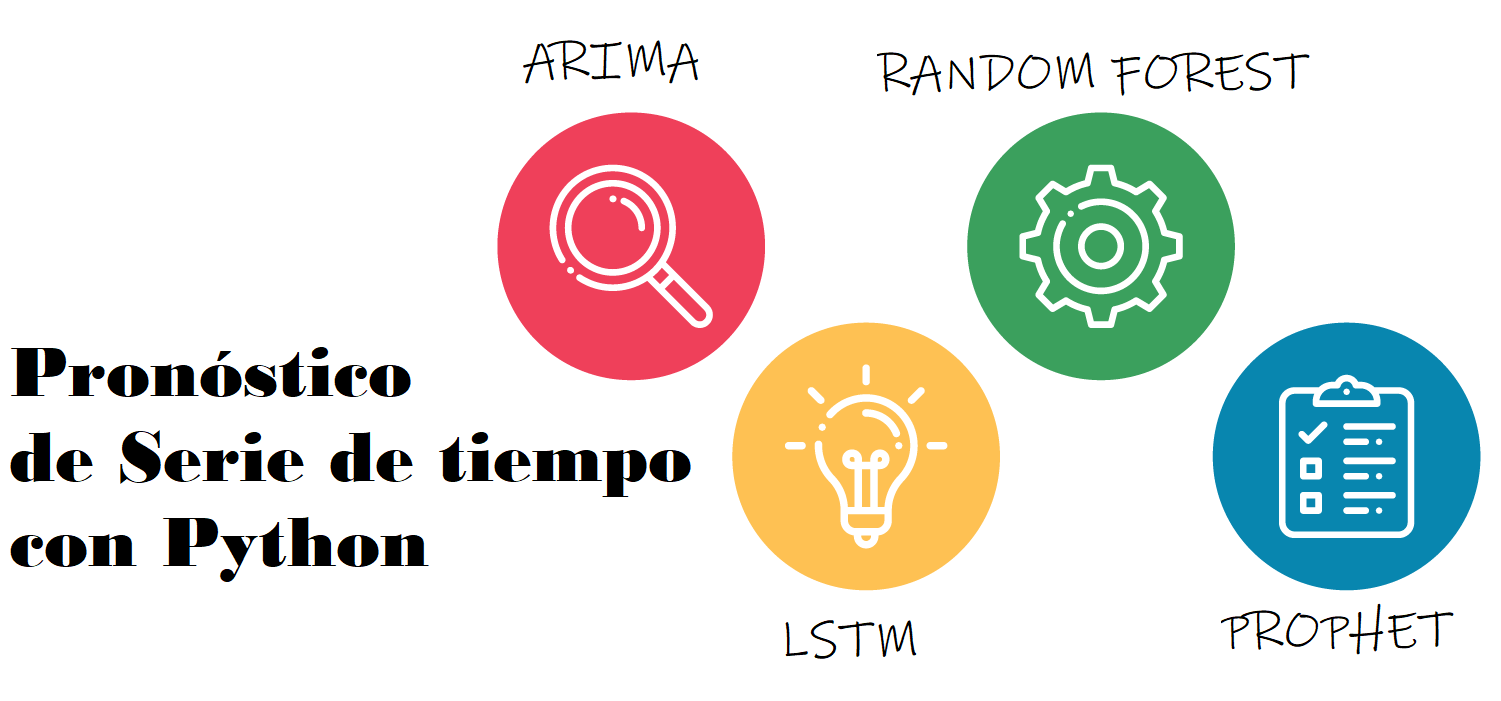

In [ ]:
#@title
from IPython.display import Image
Image("/content/drive/MyDrive/_Curso Serie de tiempo/imagen/utopico.png")

# **Autor:Naren Castellon**

## **Contenido**

1. **Introducción a Serie de tiempo**
        1.1 ¿Qué es una serie de tiempo?
       
2. **Evaluación de Modelos** 
   
3. **Modelo Arima**
        3.1 Definición Matemática de Modelo Arima
        3.2 Leemos datos
        3.3 Análisis Exploratorio de Datos (EDA)
        3.4 Prueba de Dickey Fuller Aumentada (ADF)
        3.5 División de datos para entrenamiento y prueba
        3.6 Modelo con Auto-Arima
        3.7 Implementación del modelo
4. **Modelo LSTM**
        4.1 Estandarización de los datos
        4.2 Modelación con LSTM
        4.3 Evaluación del modelo
5. **Modelo Random Forest**
        5.1 Idea intuitiva detrás de los Bosques Aleatorios
        5.2 Feature Change
        5.3 Implementación del Modelo Random Forest
        5.4 Evaluación del modelo
6. **Modelo Prophet**
        6.1 Modelación del modelo Prophet
        6.2 Evaluación del modelo
7. **Conclusión**

## 1.1 **¿Qué es una Serie de Tiempo?**

Una serie de tiempo es una secuencia de datos u observaciones, medidos en determinados momentos y ordenados cronológicamente. Visualmente, es una curva que evoluciona en el tiempo. Una serie de tiempo es un conjunto de observaciones sobre los valores que toma una variable (cuantitativa) a través del tiempo.

**Ejemplo de algunas aplicaciones de datos de serie temporal**

1. Anual: - PIB, serie macroeconómica
2. Trimestral:- Ingresos de una empresa.
3. Mensual: - Ventas, gastos, salario
4. Semanal:- Demanda, Precio de Gasolina y Diesel
5. Diariamente:- Precio de cierre de acciones, valor sensex, transacción diaria de cajero automático
6. Por hora: - AAQI

El análisis de series de tiempo puede ser útil para ver cómo cambia un activo, un valor o una variable económica dados con el tiempo. También se puede utilizar para examinar cómo los cambios asociados con el punto de datos elegido se comparan con los cambios en otras variables durante el mismo período de tiempo.


# 2. Evaluación de Modelos

Al desarrollar modelos de aprendizaje automático, generalmente comparamos varios modelos durante la fase de construcción. Luego, estimamos los rendimientos de esos modelos y se seleccionamos el modelo que considera que tiene mayor probabilidades de funcionar bien. Necesitamos medidas objetivas de desempeño para poder decidir qué pronóstico conservar como su pronóstico real. A lo largo de este cuaderno, vamos a usar numerosas herramientas para la evaluación de modelos. Veremos diferentes estrategias para evaluar modelos de aprendizaje automático en general y adaptaciones y consideraciones específicas a tener en cuenta para la previsión. 

## 2.6 Función para evaluar

In [ ]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

# 3. Pronóstico de Series de tiempo 

En este cuaderno intentaremos pronosticar una serie de datos de tiempo básicamente. Construiremos cuatro modelos diferentes con Python e inspeccionaremos sus resultados. Los modelos que utilizaremos son ARIMA (media móvil integrada autorregresiva), LSTM (red neuronal de memoria a largo plazo), Random Forest y Facebook Prophet. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Manipulación y tratamiento de Datos
import numpy as np
import pandas as pd

# Visualización de datos
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Modelación Arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

# Métrica de Evaluación
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

# No presentar advertencias
import warnings
warnings.filterwarnings("ignore")


## 3.1 ARIMA (Autoregressive Integrated Moving Average)

ARIMA es un modelo que se utiliza para predecir tendencias futuras en una serie de datos de tiempo. Es un modelo que forma de análisis de regresión. El modelo Arima esta compuesto por 3 término:
* **AR (Autoregresión) :** Modelo que muestra una variable cambiante que retrocede sobre sus propios valores atrasados/anteriores.
* **I (Integrado) :** Diferenciación de observaciones sin procesar para permitir que la serie temporal se vuelva estacionaria
* **MA (Promedio móvil) :** Dependencia entre una observación y un error residual de un modelo de promedio móvil

Para los modelos ARIMA, una notación estándar sería ARIMA con p, d y q, donde los valores enteros sustituyen a los parámetros para indicar el tipo de modelo ARIMA utilizado.

* **p:** el número de observaciones de retraso en el modelo; también conocido como el orden de retardo.
* **d:** el número de veces que se diferencian las observaciones sin procesar; también conocido como el grado de diferenciación.
* **q:** el tamaño de la ventana de promedio móvil; también conocido como el orden de la media móvil.

### Definición del modelo
El modelo ARIMA es la abreviatura del modelo Autoregresivo de Media Móvil Integrada. La diferencia con el modelo ARMA es pequeña: solo hay un efecto adicional que hace que la serie temporal no sea estacionaria. Un ejemplo simple de esto sería una tendencia lineal creciente, como se muestra en la siguiente ecuación:

$$X_t= c+\epsilon_t+ \sum_{i=1}^{p}\phi_i X_{t-i}+\sum_{i=1}^{q} \theta_i \epsilon_{t-i}+\delta_t $$

Al diferenciar una serie temporal, en realidad comienza a modelar las diferencias de un paso a otro en lugar de los valores originales. Si los valores reales de una variable no son estables en el tiempo, aún es posible que las diferencias sean estables en el tiempo.

La tendencia lineal es un gran ejemplo de esto. Imagine una tendencia lineal que comienza desde 0 y se incrementa en 2 cada paso de tiempo. Los valores no serán para nada estacionarios: aumentarán infinitamente. Sin embargo, la diferencia entre cada valor y el siguiente es siempre 2, por lo que la serie temporal diferenciada es perfectamente estacionaria.

## 3.2 Leemos los datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/_Curso Serie de tiempo/data/df_furniture.csv")
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


## 3.3 Análisis Exploratorio de Datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     331 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


Como podemos ver la variable `Month` es una variabe del tipo objeto, debemos convertir esa variable a un formato de tiempo.

In [ ]:
# Convertir a un formato de datetime
from datetime import datetime
df['Month'] = pd.to_datetime(df['Month'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     331 non-null    datetime64[ns]
 1   furniture_price_adjusted  331 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.3 KB


In [ ]:
df = df.set_index("Month")
df.head()

,furniture_price_adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [ ]:
df.index.freq = 'MS'

In [ ]:
df.head()

,furniture_price_adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [ ]:
fig = px.line(df, x=df.index, y="furniture_price_adjusted",template = "plotly_dark",
              title="Precio de Venta Furniture")
fig.show()

Cuando miramos el gráfico, podemos ver que hay una estacionalidad en los datos. Es por eso que usaremos SARIMA (Seasonal ARIMA) en lugar de ARIMA.


## 3.4 La prueba de Dickey-Fuller aumentada
Una prueba de Dickey-Fuller aumentada (ADF) es un tipo de prueba estadística que determina si una raíz unitaria está presente en los datos de series de tiempo. Las raíces unitarias pueden causar resultados impredecibles en el análisis de series de tiempo. Se forma una hipótesis nula en la prueba de raíz unitaria para determinar qué tan fuertemente los datos de series temporales se ven afectados por una tendencia. Al aceptar la hipótesis nula, aceptamos la evidencia de que los datos de la serie temporal no son estacionarios. Al rechazar la hipótesis nula o aceptar la hipótesis alternativa, aceptamos la evidencia de que los datos de la serie de tiempo son generados por un proceso estacionario. Este proceso también se conoce como tendencia estacionaria. Los valores de la estadística de prueba ADF son negativos. Los valores más bajos de ADF indican un rechazo más fuerte de la hipótesis nula.


In [ ]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [ ]:
Prueba_Dickey_Fuller(df["furniture_price_adjusted"],"furniture_price_adjusted")

Resultados de la prueba de Dickey-Fuller para columna: furniture_price_adjusted
Test Statistic                         -1.128551
p-value                                 0.703553
No Lags Used                           14.000000
Número de observaciones utilizadas    316.000000
Critical Value (1%)                    -3.451215
Critical Value (5%)                    -2.870730
Critical Value (10%)                   -2.571666
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


Podemos observar en el resultado que obtuvismo que la serie no estacionaria, debido a que el p-value es mayor que 5%.

Uno de los objetivo de aplicar la prueba ADF es conocer si nuestra series es estacionaria, al conocer el resultado de la prueba ADF, entonces podemos determinar el siguiente paso. Para nuestro caso, se puede ver en el resultado anterior que la serie no es estacionar, por lo que procederemos al siguiente paso, que es diferenciar nuestra serie.

In [ ]:
df1=df.copy()
# Take first difference
df1['furniture_diff'] = df['furniture_price_adjusted'].diff()

# Remove the first data point
df1.dropna(inplace=True)

# Take a look at the head of the dataset
df1.head()

,furniture_price_adjusted,furniture_diff
Month,,
1992-02-01,2114.485812,41.053088
1992-03-01,2260.570891,146.085079
1992-04-01,2255.103236,-5.467655
1992-05-01,2331.414618,76.311382
1992-06-01,2384.638567,53.223949


In [ ]:
Prueba_Dickey_Fuller(df1["furniture_diff"],"furniture_diff")

Resultados de la prueba de Dickey-Fuller para columna: furniture_diff
Test Statistic                         -3.117451
p-value                                 0.025288
No Lags Used                           17.000000
Número de observaciones utilizadas    312.000000
Critical Value (1%)                    -3.451484
Critical Value (5%)                    -2.870849
Critical Value (10%)                   -2.571730
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios



> Seasonal ARIMA, es una extensión de ARIMA que admite explícitamente datos de series temporales univariadas con un componente estacional.
> Agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), diferenciación (I) y media móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de la estacionalidad.

> Hay cuatro elementos estacionales que no forman parte de ARIMA que deben configurarse; ellos son:<br>
**P:** orden autorregresivo estacional.<br>
**D:** Orden de diferencia estacional.<br>
**P:** Orden promedio móvil estacional.<br>
**m:** El número de pasos de tiempo para un solo período estacional.<br>

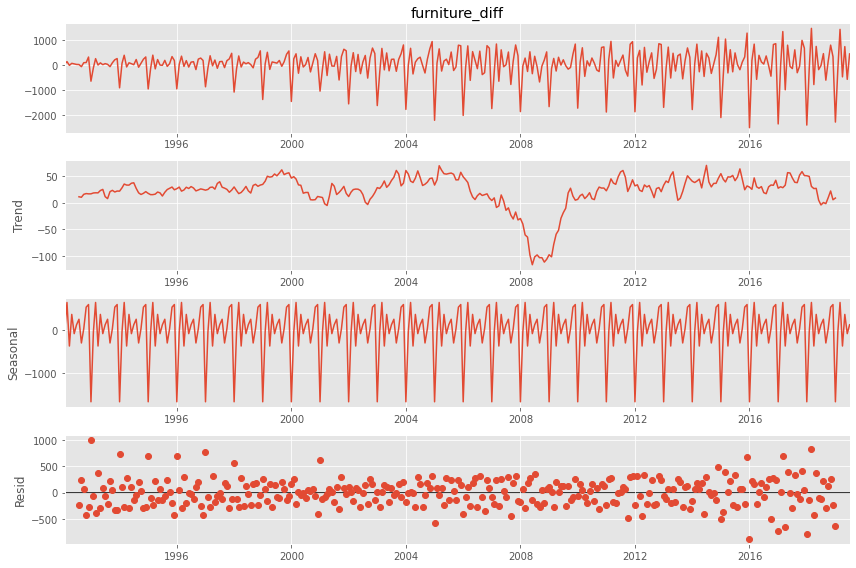

In [ ]:
plt.rcParams["figure.figsize"] = (12, 8)
a = seasonal_decompose(df1["furniture_diff"], model = "add")
a.plot();

## 3.5 División de para entrenamiento y prueba

In [ ]:
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]
test=test_data.copy()

In [ ]:
train_data.shape, test_data.shape

((319, 1), (12, 1))

In [ ]:
test_data

,furniture_price_adjusted
Month,
2018-08-01,10010.598100
2018-09-01,9407.297340
2018-10-01,9569.037851
2018-11-01,10380.194097
2018-12-01,10726.595075
2019-01-01,8431.965334
2019-02-01,8271.237355
2019-03-01,9718.107698
2019-04-01,9248.814254


## 3.6 Modelo Auto-Arima

Ejecutemos la función `auto_arima()` para obtener los mejores parametros de p,d,q,P,D,Q

**Nota:** El parámetro $m$ se refiere al número de periodo para cada estacionalidad
* 7 para los días
* 12 para los meses
* 52 para las semanas
* 4 Trimestral
* 1 Anual

In [ ]:
# Modelo Auto-Arima
from pmdarima import auto_arima   

In [ ]:
modelo_auto=auto_arima(train_data,start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4169.959, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4106.391, Time=0.82 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4076.493, Time=1.28 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4095.669, Time=0.33 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4061.495, Time=2.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4087.151, Time=0.76 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4057.488, Time=6.17 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4075.752, Time=1.91 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=4045.407, Time=10.50 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4059.986, Time=3.95 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=5.35 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=4047.345, Time=8.36 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=4047.314, Time=6.56 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(1,1,2)(2,1,2)[12]    

Como podemos ver, el mejor modelo de arima elegido por auto_arima() es SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)

In [ ]:
print(modelo_auto.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  319
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2016.704
Date:                                 Fri, 02 Sep 2022   AIC                           4045.407
Time:                                         02:33:43   BIC                           4067.749
Sample:                                     01-01-1992   HQIC                          4054.342
                                          - 07-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4014      0.043     -9.353      0.000      -0.485      -0

## **3.7 Implementación del Modelo**

In [ ]:
arima_model = SARIMAX(train_data["furniture_price_adjusted"], order = (0,1,1), seasonal_order = (2,1,2,12)) 
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                furniture_price_adjusted   No. Observations:                  319
Model:             SARIMAX(0, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood               -2016.704
Date:                                 Fri, 02 Sep 2022   AIC                           4045.407
Time:                                         02:35:07   BIC                           4067.749
Sample:                                     01-01-1992   HQIC                          4054.342
                                          - 07-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4014      0.043     -9.353      0.000      -0.485      -0.317
ar.S.L12       0.8930      0.090      9.974      0.000       0.717       1.068
ar.S.L24      -0.7698      0.081     -9.449      0.000      -0.929      -0.610
ma.S.L12      -1.1505      0.106    -10.884      0.000      -1.358      -0.943
ma.S.L24       0.7396      0.099      7.449      0.000       0.545       0.934
sigma2      2.997e+04   2096.303     14.295      0.000    2.59e+04    3.41e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                21.70
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.95   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

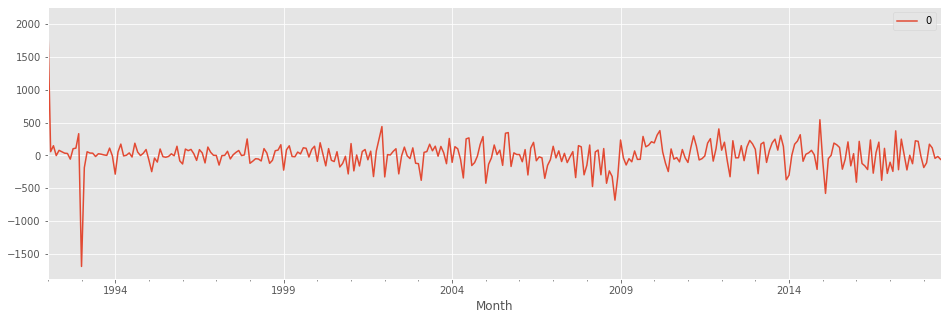

In [ ]:
# Gráfico de línea de errores residuales
residuals = pd.DataFrame(arima_result.resid)
residuals.plot(figsize = (16,5));
plt.show();

### **Cómo interpretar las gráficas de residuos en el modelo ARIMA**
Repasemos las gráficas de residuos usando stepwise_fit.

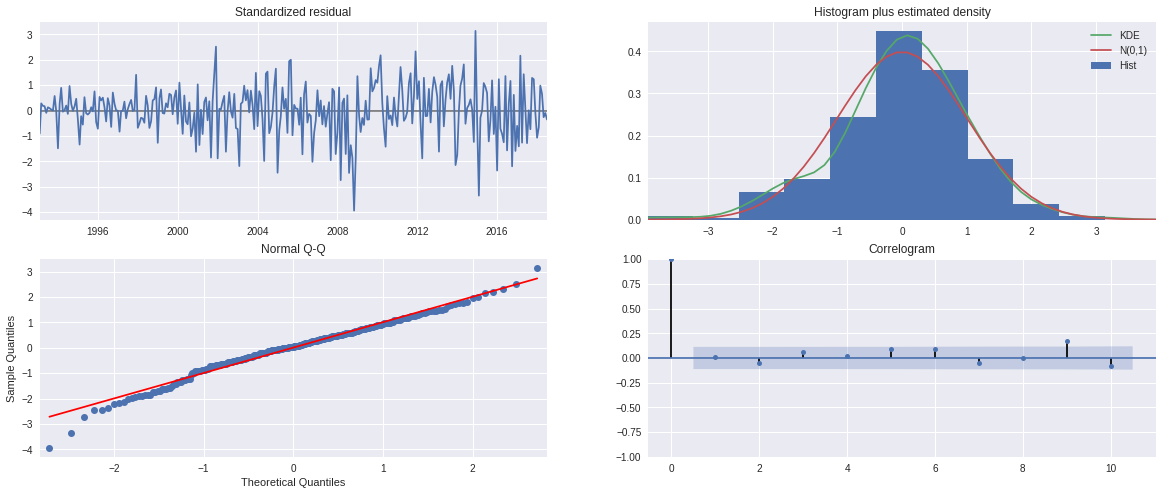

In [ ]:
plt.style.use('seaborn')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

Entonces, ¿cómo interpretar los diagnósticos de la trama?

Arriba a la izquierda: los errores residuales parecen fluctuar alrededor de una media de cero y tienen una varianza uniforme.

Arriba a la derecha: la gráfica de densidad sugiere una distribución normal con media cero.

Abajo a la izquierda: todos los puntos deben estar perfectamente alineados con la línea roja. Cualquier desviación significativa implicaría que la distribución está sesgada.

Abajo a la derecha: el correlograma, también conocido como gráfico ACF, muestra que los errores residuales no están autocorrelacionados. Cualquier autocorrelación implicaría que existe algún patrón en los errores residuales que no se explican en el modelo. Por lo tanto, deberá buscar más X (predictores) en el modelo.

En general, parece encajar bien. Pronostiquemos.

**Forma 1**

In [ ]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2018-08-01    10146.951765
2018-09-01     9740.513249
2018-10-01     9842.238682
2018-11-01    10656.847764
2018-12-01    11394.208645
2019-01-01     9030.427702
2019-02-01     8797.014457
2019-03-01    10110.145602
2019-04-01     9516.779661
2019-05-01    10268.653757
2019-06-01    10048.200349
2019-07-01    10179.643991
Freq: MS, Name: ARIMA Predictions, dtype: float64

Si queremos estimar o predecir otros periodos diferente de los datos de entrenamiento lo podemos hacer de la siguiente manera, escribiendo las fechas de inicio y la fecha final donde queremos hacer la predicción.

**Forma 2**

In [ ]:
arima_pred2 = arima_result.predict(start='2015-01-01',end='2025-01-01', typ="levels").rename("ARIMA Predictions")
arima_pred2

2015-01-01     7346.789714
2015-02-01     7465.068318
2015-03-01     7991.354835
2015-04-01     7629.713410
2015-05-01     8068.349658
                  ...     
2024-09-01    11952.544179
2024-10-01    11995.576780
2024-11-01    12779.269598
2024-12-01    13557.642236
2025-01-01    11137.707612
Freq: MS, Name: ARIMA Predictions, Length: 121, dtype: float64

Grafiquemos ambos casos:

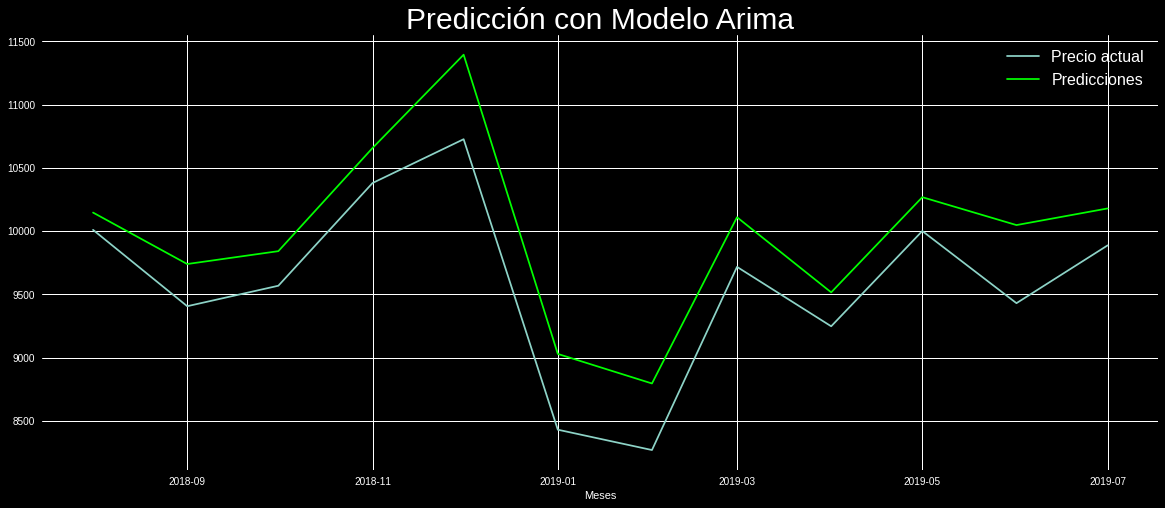

In [ ]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["furniture_price_adjusted"], label="Precio actual")
plt.plot(arima_pred, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

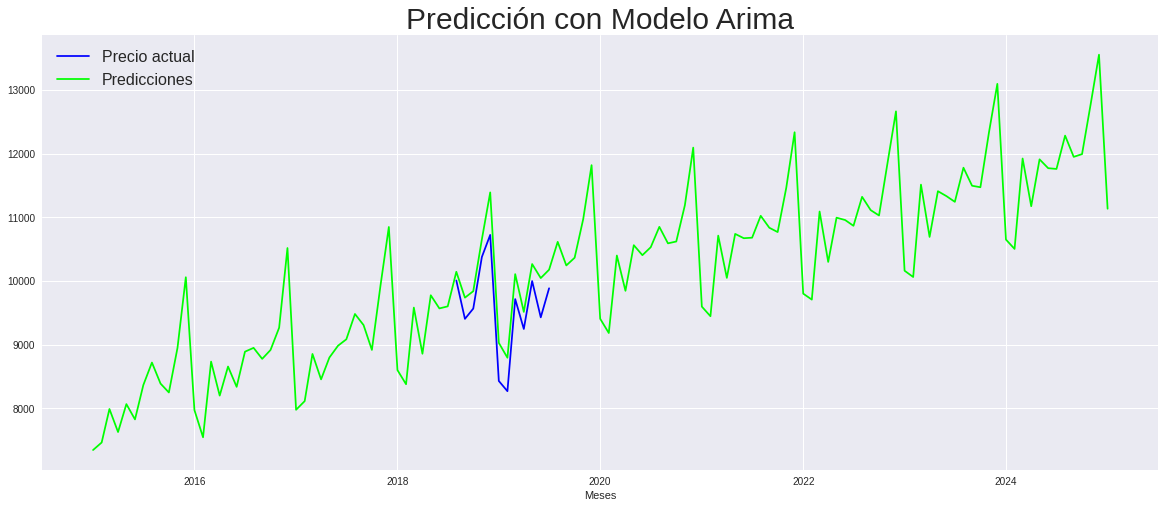

In [ ]:
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (20, 8)

plt.plot(test_data["furniture_price_adjusted"],color="blue" ,label="Precio actual")
plt.plot(arima_pred2, color="lime", label="Predicciones")
plt.title("Predicción con Modelo Arima", fontsize=30);
plt.xlabel('Meses')
plt.ylabel('')
plt.legend( fontsize=16);
plt.show();

Podemos ver que la predicciones tiene un comportamiento parecido a los datos originales.

In [ ]:
evaluacion_metrica(test_data,arima_pred)

Evaluation metric results:-
MSE is : 176981.22914176827
MAE is : 387.2779415186028
RMSE is : 420.6913704151397
MAPE is : 8.732071412429567
R2 is : 0.6223061328416106



Guardemos los datos, para luego hacer unas comparaciones con los demás modelos.

In [ ]:
test_data['ARIMA_Predictions'] = arima_pred

In [ ]:
test_data

,furniture_price_adjusted,ARIMA_Predictions
Month,,
2018-08-01,10010.598100,10146.951765
2018-09-01,9407.297340,9740.513249
2018-10-01,9569.037851,9842.238682
2018-11-01,10380.194097,10656.847764
2018-12-01,10726.595075,11394.208645
2019-01-01,8431.965334,9030.427702
2019-02-01,8271.237355,8797.014457
2019-03-01,9718.107698,10110.145602
2019-04-01,9248.814254,9516.779661


# 4. LSTM Forecast

> LSTM significa memoria a corto plazo. Es un modelo o arquitectura que amplía la memoria de las redes neuronales recurrentes. Por lo general, las redes neuronales recurrentes tienen "memoria a corto plazo" en el sentido de que utilizan información anterior persistente para ser utilizada en la red neuronal actual. Esencialmente, la información anterior se utiliza en la presente tarea. Eso significa que no tenemos una lista de toda la información anterior disponible para el nodo neuronal.
> LSTM introduce la memoria a largo plazo en las redes neuronales recurrentes. Mitiga el problema del gradiente de fuga, que es donde la red neuronal deja de aprender porque las actualizaciones de los diversos pesos dentro de una red neuronal dada se vuelven cada vez más pequeñas. Lo hace mediante el uso de una serie de "puertas". Estos están contenidos en bloques de memoria que están conectados a través de capas, así:

![](https://hub.packtpub.com/wp-content/uploads/2018/04/LSTM-696x494.png)

> trabajo LSTM
Hay tres tipos de puertas dentro de una unidad:
Puerta de entrada: escala la entrada a la celda (escritura)
Puerta de salida: escala la salida a la celda (lectura)
Forget Gate: escala el valor de la celda anterior (restablecer)
Cada puerta es como un interruptor que controla la lectura/escritura, incorporando así la función de memoria a largo plazo en el modelo.



## 4.1 Estandarización 
Primero escalaremos nuestro datos de entrenamiento y probaremos los datos con MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)

scaled_test_data = scaler.transform(test)

Antes de crear el modelo LSTM, debemos crear un objeto Generador de series temporales.

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

## 4.2 Modelación

## 4.2.1 Parámetros clave para LSTM con Keras
Veamos los parámetros clave para ajustar el modelo LSTM.

* **hidden_layer_sizes:** Debe proporcionar una cantidad de capas ocultas y neuronas para cada capa oculta. Por ejemplo, hidden_layer_sizes – (5,3,3) significa que hay tres capas ocultas y el número de neuronas para la capa uno es 5, para la capa dos es 3 y para la capa tres es 3, respectivamente. El valor predeterminado es (100), es decir, una capa oculta con 100 neuronas.
* **activation:** Esta es la función de activación de una capa oculta; hay cuatro funciones de activación disponibles para su uso; el valor predeterminado es "relu".
     * relu: La función de unidad lineal rectificada, devuelve $f(x) = max(0, x)$
     * logística: La función sigmoidea logística, devuelve f(x) = 1 / (1 + exp(-x)).
     * identidad: activación sin operación, útil para implementar un cuello de botella lineal, devuelve f(x) = x
     * tanh: La función tan hiperbólica, devuelve $f(x) = tanh(x)$.
* **solver:** Esto es para optimizar el peso. Hay tres opciones disponibles, la predeterminada es "adam".
     * adam: Optimizador basado en gradiente estocástico propuesto por Diederik Kingma y Jimmy Ba, que funciona bien para un gran conjunto de datos
     * lbfgs: Pertenece a la familia de métodos cuasi-Newton, funciona bien para conjuntos de datos pequeños
     * sgd: Descenso de gradiente estocástico
* **max_iter:** Este es el número máximo de iteraciones para que el solucionador converja, el valor predeterminado es 200.
* **learning_rate_init:** Esta es la tasa de aprendizaje inicial para controlar el tamaño de paso para actualizar los pesos (solo se aplica a los solucionadores sgd/ adam), el valor predeterminado es 0,001.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=100)

Epoch 1/100
307/307 [==============================] - 10s 14ms/step - loss: 0.0133
Epoch 2/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0055
Epoch 3/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0055
Epoch 4/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0055
Epoch 5/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0046
Epoch 6/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0046
Epoch 7/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0046
Epoch 8/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0037
Epoch 9/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0037
Epoch 10/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0029
Epoch 11/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0031
Epoch 12/100
307/307 [==============================] - 3s 9ms/step - loss: 0.0024
Epoch 13/10

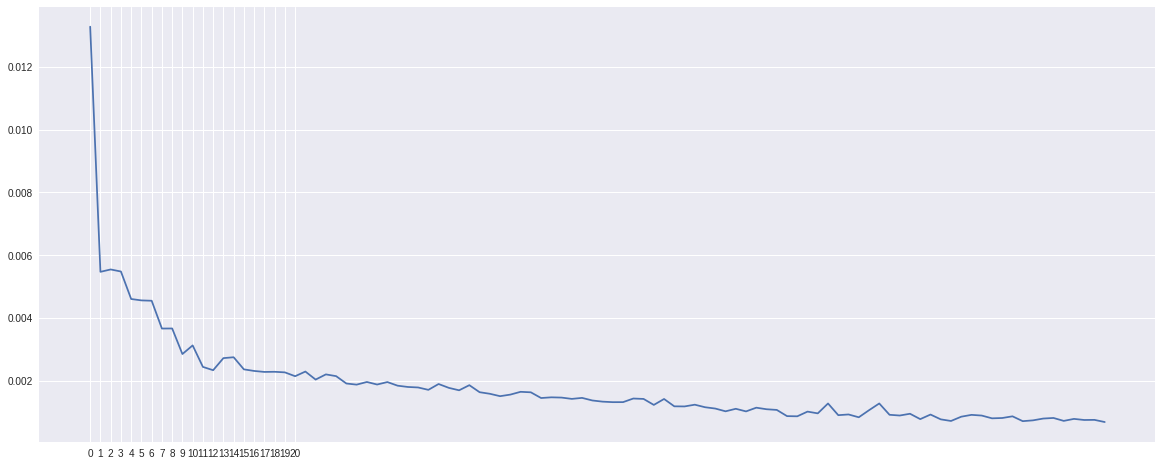

In [ ]:
losses_lstm = lstm_model.history.history['loss']
#plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

Como saben, escalamos nuestros datos, por eso tenemos que invertirlos para ver predicciones verdaderas.

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [ ]:
lstm_predictions

array([[10081.85144062],
       [ 9786.0978331 ],
       [10099.8036859 ],
       [10808.07359497],
       [11464.24063918],
       [ 8949.85486683],
       [ 8746.86218467],
       [10162.59216242],
       [ 9079.85487465],
       [ 9803.44648361],
       [ 9647.75505944],
       [ 9552.24610701]])

Guardamos las predicciones para compararla con las verdaderas y el modelo Arima

In [ ]:
test_data['LSTM_Predictions'] = lstm_predictions

In [ ]:
test_data

,furniture_price_adjusted,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
2018-08-01,10010.598100,10146.951765,10081.851441,9839.170376
2018-09-01,9407.297340,9740.513249,9786.097833,9578.789038
2018-10-01,9569.037851,9842.238682,10099.803686,9625.131270
2018-11-01,10380.194097,10656.847764,10808.073595,10173.020991
2018-12-01,10726.595075,11394.208645,11464.240639,10830.870566
2019-01-01,8431.965334,9030.427702,8949.854867,9212.192460
2019-02-01,8271.237355,8797.014457,8746.862185,9231.700381
2019-03-01,9718.107698,10110.145602,10162.592162,9797.065863
2019-04-01,9248.814254,9516.779661,9079.854875,9506.002313


Graficamos las predicciones con los datos originales

In [ ]:
ai=test_data[["furniture_price_adjusted","LSTM_Predictions"]]
fig = px.line(ai, x=test_data.index, y=ai.columns,title="Predicción con Modelo LSTM", template = "plotly_dark")
fig.show()

## 4.3 Evaluación

In [ ]:
evaluacion_metrica(test_data["furniture_price_adjusted"],test_data["LSTM_Predictions"])

Evaluation metric results:-
MSE is : 173050.4159210115
MAE is : 375.2611806299933
RMSE is : 415.99328831245765
MAPE is : 3.9369630202659636
R2 is : 0.6306948419359275



# 5. Random Forest
Vamos a descubrirá el modelo Random Forest. Es un modelo fácil de usar y se sabe que tiene un gran rendimiento. Random Forest y el modelo XGBoost, son dos de los algoritmos de aprendizaje automático más utilizados en las aplicaciones modernas.

Existe una gran cantidad de variantes en Random Forests y XGBoost en el mercado, pero si comprende los dos conceptos básicos, será relativamente fácil adaptarse a cualquier variante.

## 5.1 Idea intuitiva detrás de los bosques aleatorios
Random Forest se basa fuertemente en el modelo Decision Tree pero le agrega más complejidad. Como sugiere el nombre, un bosque aleatorio consta de una gran cantidad de árboles de decisión, cada uno de ellos con una ligera variación.

Un bosque aleatorio tiene mucho más rendimiento que un árbol de decisión. Generalmente, un bosque aleatorio puede combinar cientos o incluso miles de modelos de árboles de decisión. Se ajustarán a datos ligeramente diferentes, para que no sean totalmente iguales. Entonces, en resumen, es una gran cantidad de árboles de decisión que hacen predicciones que deberían ser cercanas entre sí, pero no exactamente iguales.

Donde un modelo de aprendizaje automático a veces puede ser incorrecto, es menos probable que la predicción promedio de una gran cantidad de modelos de aprendizaje automático sea incorrecta. Esta idea es la base del aprendizaje conjunto.

En Random Forest, el aprendizaje conjunto se aplica a una repetición de muchos árboles de decisión. El aprendizaje de conjunto se puede aplicar a cualquier combinación de una gran cantidad de modelos de aprendizaje automático. La razón para usar Decision Trees es que se ha demostrado que es un modelo eficaz y fácil de configurar.

In [ ]:
df5 = pd.read_csv("/content/drive/MyDrive/_Curso Serie de tiempo/data/df_furniture.csv")
df5.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


### Percentage Change
Recordemos que la unidad original estaba en millones de dólares, que son las ventas de muebles y artículos para el hogar.
Un tipo de diferenciación es el cambio porcentual, que normalmente se aplica a unidades monetarias en montos de precios o ventas en dólares.

Entre cada punto de datos, podemos calcular el cambio porcentual. Tendremos que eliminar el primer punto de datos, ya que se convertirá en un Nan.

In [ ]:
df5['furniture_pct_change']= df5['furniture_price_adjusted'].pct_change()
df5.dropna(inplace=True)
df5.head()

,Month,furniture_price_adjusted,furniture_pct_change
1,1992-02-01,2114.485812,0.019800
2,1992-03-01,2260.570891,0.069088
3,1992-04-01,2255.103236,-0.002419
4,1992-05-01,2331.414618,0.033839
5,1992-06-01,2384.638567,0.022829


In [ ]:
df5['furniture_pct_change'].describe()

count    330.000000
mean       0.009588
std        0.094790
min       -0.284492
25%       -0.032020
50%        0.022959
75%        0.073826
max        0.179970
Name: furniture_pct_change, dtype: float64

In [ ]:
fig = px.line(df5, x="Month", y="furniture_pct_change",template = "plotly_dark",
              title="Porcentaje de Cambio")
fig.show()

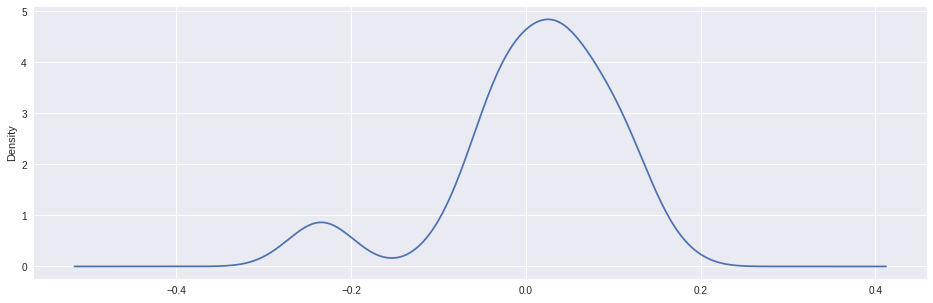

In [ ]:
df5['furniture_pct_change'].plot(kind='kde',figsize = (16,5));

Ahora es necesario agregar algo de ingeniería de funciones. Agreguemos las variables Año y Mes para tener en cuenta la estacionalidad y las versiones rezagadas de la variable objetivo durante los últimos 12 meses. Se puede esperar que esta tarea sea un poco más difícil, ya que hay una variación más detallada que el modelo necesita aprender. 

## 5.2 Feature engineering

In [ ]:
# Variables de estacionalidad
df5['Month'] = pd.to_datetime(df5['Month'])
df5['Year'] = df5['Month'].apply(lambda x: x.year)
df5['Mes'] = df5['Month'].apply(lambda x: x.month)
df5.head()

,Month,furniture_price_adjusted,furniture_pct_change,Year,Mes
1,1992-02-01,2114.485812,0.019800,1992,2
2,1992-03-01,2260.570891,0.069088,1992,3
3,1992-04-01,2255.103236,-0.002419,1992,4
4,1992-05-01,2331.414618,0.033839,1992,5
5,1992-06-01,2384.638567,0.022829,1992,6


In [ ]:
# Agregar un año de datos retrasados
df5['L1'] = df5["furniture_pct_change"].shift(1)
df5['L2'] = df5["furniture_pct_change"].shift(2)
df5['L3'] = df5["furniture_pct_change"].shift(3)
df5['L4'] = df5["furniture_pct_change"].shift(4)
df5['L5'] = df5["furniture_pct_change"].shift(5)
df5['L6'] = df5["furniture_pct_change"].shift(6)
df5['L7'] = df5["furniture_pct_change"].shift(7)
df5['L8'] = df5["furniture_pct_change"].shift(8)
df5['L9'] = df5["furniture_pct_change"].shift(9)
df5['L10'] = df5["furniture_pct_change"].shift(10)
df5['L11'] = df5["furniture_pct_change"].shift(11)
df5['L12'] = df5["furniture_pct_change"].shift(12)

In [ ]:
df5.head(13)

,Month,furniture_price_adjusted,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
1,1992-02-01,2114.485812,0.019800,1992,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1992-03-01,2260.570891,0.069088,1992,3,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1992-04-01,2255.103236,-0.002419,1992,4,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1992-05-01,2331.414618,0.033839,1992,5,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1992-06-01,2384.638567,0.022829,1992,6,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1992-07-01,2417.165376,0.013640,1992,7,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1992-08-01,2445.498729,0.011722,1992,8,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN,NaN
8,1992-09-01,2387.351705,-0.023777,1992,9,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN,NaN
9,1992-10-01,2489.350838,0.042725,1992,10,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN,NaN
10,1992-11-01,2598.186297,0.043720,1992,11,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800,NaN,NaN,NaN


Ahora que tiene un conjunto de datos, hagamos una división de prueba de entrenamiento y ajustemos el Random Forest con los hiperparámetros predeterminados. 

In [ ]:
df5 = df5.dropna()
df5.head()

,Month,furniture_price_adjusted,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
13,1993-02-01,2183.137948,-0.044419,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
14,1993-03-01,2449.195623,0.121869,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
15,1993-04-01,2457.704334,0.003474,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419
16,1993-05-01,2552.874950,0.038723,1993,5,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839
17,1993-06-01,2575.018055,0.008674,1993,6,0.038723,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829


In [ ]:
df5= df5.set_index("Month")
df5.head()

,furniture_price_adjusted,furniture_pct_change,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Month,,,,,,,,,,,,,,,,
1993-02-01,2183.137948,-0.044419,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
1993-03-01,2449.195623,0.121869,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
1993-04-01,2457.704334,0.003474,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419
1993-05-01,2552.874950,0.038723,1993,5,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839
1993-06-01,2575.018055,0.008674,1993,6,0.038723,0.003474,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829


## 5.3 Modelación

In [ ]:
# dividir en variables rezagadas (características) y datos de series de tiempo originales (objetivo)
X2= df5.iloc[:,2:] # dividir todas las filas y comenzar con la columna 0 y subir hasta la última columna, pero sin incluirla
y2 = df5.iloc[:,1] # dividir todas las filas y la última columna, esencialmente separando la columna 't'

In [ ]:
X2.head(3)

,Year,Mes,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,L11,L12
Month,,,,,,,,,,,,,,
1993-02-01,1993,2,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088,0.019800
1993-03-01,1993,3,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419,0.069088
1993-04-01,1993,4,0.121869,-0.044419,-0.219927,0.127219,0.043720,0.042725,-0.023777,0.011722,0.013640,0.022829,0.033839,-0.002419


In [ ]:
y2.head()

Month
1993-02-01   -0.044419
1993-03-01    0.121869
1993-04-01    0.003474
1993-05-01    0.038723
1993-06-01    0.008674
Name: furniture_pct_change, dtype: float64

In [ ]:
# Target Train-Test split
from pandas import read_csv

Y2 = y2
traintarget_size = int(len(Y2) * 0.80)   # Set split
train_target, test_target = Y2[0:traintarget_size], Y2[traintarget_size:len(Y2)]

print('Observaciones para el objetivo: %d' % (len(Y2)))
print('Observaciones de entrenamiento para el objetivo: %d' % (len(train_target)))
print('Observaciones de prueba para el objetivo: %d' % (len(test_target)))

Observaciones para el objetivo: 318
Observaciones de entrenamiento para el objetivo: 254
Observaciones de prueba para el objetivo: 64


In [ ]:
# Features Train-Test split

trainfeature_size = int(len(X2) * 0.80)
train_feature, test_feature = X2[0:trainfeature_size], X2[trainfeature_size:len(X2)]
print('Observaciones para la característica: %d' % (len(X2)))
print('Observaciones de entrenamiento para la característica: %d' % (len(train_feature)))
print('Observaciones de prueba para la característica: %d' % (len(test_feature)))

Observaciones para la característica: 318
Observaciones de entrenamiento para la característica: 254
Observaciones de prueba para la característica: 64


In [ ]:
# Creando Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2,  shuffle=False)

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo con 500 árboles
rfr = RandomForestRegressor(n_estimators=500)

# Entrenamos el modelo
rfr.fit(train_feature, train_target)

# Hacemos las predicciones 
fcst = rfr.predict(test_feature)

In [ ]:
b=pd.DataFrame({"Actual":test_target, "Random Forest":fcst})
b

,Actual,Random Forest
Month,,
2014-04-01,-0.035453,-0.050189
2014-05-01,0.079872,0.062860
2014-06-01,-0.058245,-0.025249
2014-07-01,0.065819,0.038881
2014-08-01,0.037654,0.034073
...,...,...
2019-03-01,0.174928,0.113049
2019-04-01,-0.048291,-0.054599
2019-05-01,0.081361,0.077423


In [ ]:
#b.set_index("2018-08-01")
#b=b.loc['2018-08-01':"2019-07-01"]

In [ ]:
fig = px.line(b, x=b.index, y=b.columns,template = "plotly_dark",
              title="Predicción con Modelo Random Forest")
fig.show()

Parece que Random Forest se ajusto bien, los valores pronosticados siguen los valores reales.

## 5.4 Evaluamos el modelo

In [ ]:
evaluacion_metrica(test_target,fcst)

Evaluation metric results:-
MSE is : 0.0007720577054974235
MAE is : 0.02181536773415873
RMSE is : 0.027785926392643875
MAPE is : 205.8152641562673
R2 is : 0.9153089118564433



# 6. Prophet Forecast

> Prophet es un procedimiento para pronosticar datos de series temporales basado en un modelo aditivo en el que las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, además de los efectos de las vacaciones. Funciona mejor con series temporales que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es resistente a los datos faltantes y los cambios en la tendencia, y por lo general maneja bien los valores atípicos.

In [ ]:
import pandas as pd
from prophet import Prophet

In [ ]:
df6 = df.copy()
df6.head()

,furniture_price_adjusted
Month,
1992-01-01,2073.432724
1992-02-01,2114.485812
1992-03-01,2260.570891
1992-04-01,2255.103236
1992-05-01,2331.414618


In [ ]:
df6=df6.reset_index()

In [ ]:
df_fb=df6.rename(columns={"Month":"ds", "furniture_price_adjusted":"y"} )
df_fb.head()

,ds,y
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [ ]:
train_data_pr = df_fb.iloc[:len(df6)-12]
test_data_pr = df_fb.iloc[len(df6)-12:]

## 6.1 Modelación

In [ ]:
from prophet import Prophet

In [ ]:
m = Prophet()

# Hacemos el entrenamiento
m.fit(train_data_pr)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw0jq81_r/pwyhoskl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw0jq81_r/g_14u27t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8431', 'data', 'file=/tmp/tmpw0jq81_r/pwyhoskl.json', 'init=/tmp/tmpw0jq81_r/g_14u27t.json', 'output', 'file=/tmp/tmpm61sem88/prophet_model-20220902030002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:00:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=12,freq='MS')
prophet_pred = m.predict(future)

In [ ]:
prophet_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1992-01-01,2259.630149,1350.388675,1933.367879,2259.630149,2259.630149,-610.957145,-610.957145,-610.957145,-610.957145,-610.957145,-610.957145,0.0,0.0,0.0,1648.673004
1,1992-02-01,2282.912943,1437.418928,2003.845353,2282.912943,2282.912943,-569.819698,-569.819698,-569.819698,-569.819698,-569.819698,-569.819698,0.0,0.0,0.0,1713.093245
2,1992-03-01,2304.693622,2032.947262,2638.114093,2304.693622,2304.693622,30.028180,30.028180,30.028180,30.028180,30.028180,30.028180,0.0,0.0,0.0,2334.721802
3,1992-04-01,2327.976416,1663.840121,2246.188684,2327.976416,2327.976416,-369.711573,-369.711573,-369.711573,-369.711573,-369.711573,-369.711573,0.0,0.0,0.0,1958.264843
4,1992-05-01,2350.508152,2010.497816,2558.736141,2350.508152,2350.508152,-68.067838,-68.067838,-68.067838,-68.067838,-68.067838,-68.067838,0.0,0.0,0.0,2282.440314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,2019-03-01,9882.423634,9523.917828,10091.083419,9851.783413,9899.358888,-85.357771,-85.357771,-85.357771,-85.357771,-85.357771,-85.357771,0.0,0.0,0.0,9797.065863
327,2019-04-01,9921.087886,9226.961006,9795.704217,9882.519795,9945.857748,-415.085574,-415.085574,-415.085574,-415.085574,-415.085574,-415.085574,0.0,0.0,0.0,9506.002313
328,2019-05-01,9958.504904,9646.273001,10211.404184,9908.212194,9989.133842,-21.614447,-21.614447,-21.614447,-21.614447,-21.614447,-21.614447,0.0,0.0,0.0,9936.890457
329,2019-06-01,9997.169157,9590.589562,10158.345286,9936.525312,10035.799890,-128.791271,-128.791271,-128.791271,-128.791271,-128.791271,-128.791271,0.0,0.0,0.0,9868.377886


In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})

In [ ]:
prophet_pred = prophet_pred.set_index("Date")

In [ ]:
prophet_pred.index.freq = "MS"

In [ ]:
prophet_pred

,Pred
Date,
2018-08-01,9839.170376
2018-09-01,9578.789038
2018-10-01,9625.131270
2018-11-01,10173.020991
2018-12-01,10830.870566
2019-01-01,9212.192460
2019-02-01,9231.700381
2019-03-01,9797.065863
2019-04-01,9506.002313


In [ ]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values

In [ ]:
test_data.head()

,furniture_price_adjusted,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
2018-08-01,10010.598100,10146.951765,10627.636351,9839.170376
2018-09-01,9407.297340,9740.513249,10523.691692,9578.789038
2018-10-01,9569.037851,9842.238682,10507.764309,9625.131270
2018-11-01,10380.194097,10656.847764,11604.585823,10173.020991
2018-12-01,10726.595075,11394.208645,12559.330734,10830.870566


In [ ]:
a=test_data[["furniture_price_adjusted","Prophet_Predictions"]]
fig = px.line(a, x=test_data.index, y=a.columns,template = "plotly_dark",
              title="Predicción con Modelo Prophet")
fig.show()

## 6.2 Evaluación

In [ ]:
evaluacion_metrica(test_data["furniture_price_adjusted"],test_data["Prophet_Predictions"])

Evaluation metric results:-
MSE is : 160979.46062715878
MAE is : 285.00410501491024
RMSE is : 401.2224577801681
MAPE is : 3.179498387007119
R2 is : 0.6564553466365658



## **Resumen**

In [ ]:
fig = px.line(test_data, x=test_data.index, y=test_data.columns,template = "plotly_dark",
              title="Predicciones")
fig.show()

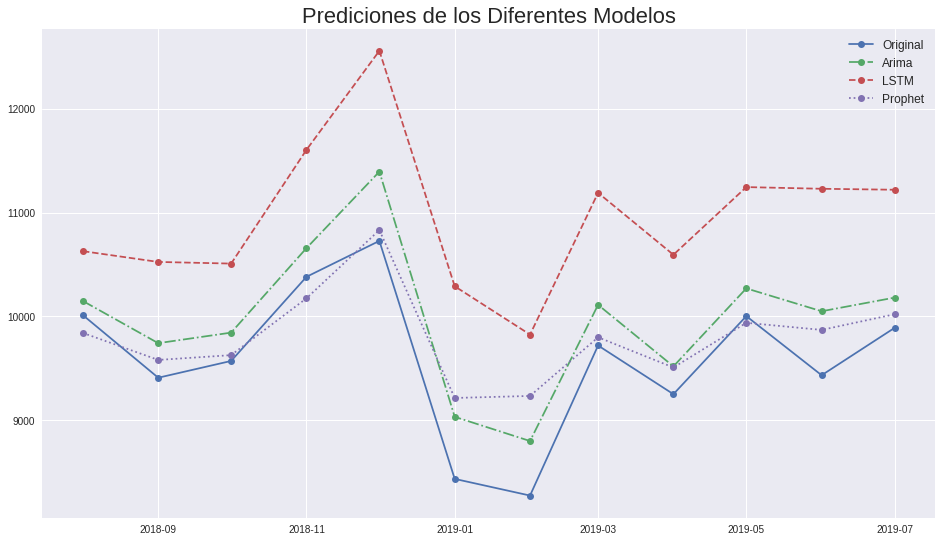

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["furniture_price_adjusted"],label="Original", linestyle="-")
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], label="Arima",linestyle="-.")
plt.plot_date(test_data.index, test_data["LSTM_Predictions"],label="LSTM", linestyle="--")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], label="Prophet",linestyle=":")
plt.legend(fontsize=12)
plt.title("Prediciones de los Diferentes Modelos", fontsize=22)
plt.show();

In [ ]:
test_data

,furniture_price_adjusted,ARIMA_Predictions,LSTM_Predictions,Prophet_Predictions
Month,,,,
2018-08-01,10010.598100,10146.951765,9919.219199,9839.170376
2018-09-01,9407.297340,9740.513249,9688.880958,9578.789038
2018-10-01,9569.037851,9842.238682,9648.758614,9625.131270
2018-11-01,10380.194097,10656.847764,10602.151703,10173.020991
2018-12-01,10726.595075,11394.208645,11400.768158,10830.870566
2019-01-01,8431.965334,9030.427702,9201.887536,9212.192460
2019-02-01,8271.237355,8797.014457,8892.939952,9231.700381
2019-03-01,9718.107698,10110.145602,10178.448534,9797.065863
2019-04-01,9248.814254,9516.779661,9581.213957,9506.002313


No olvides que son solo predicciones rápidas y básicas para que puedas mejorar estos modelos con tuning y de acuerdo a tus datos y conocimiento del negocio.